In [1]:
from openai import OpenAI
import pandas as pd
import os
import json
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Load the API key from your .env
load_dotenv(dotenv_path=".env")  # You can give it the path explicitly
# Define api_key first
api_key = os.getenv("OPENAI_API_KEY")

https://www.kaggle.com/datasets/nair26/predictive-maintenance-of-machines/data

In [2]:
print("Loaded API key:", os.getenv("OPENAI_API_KEY")[:8] + "..." if os.getenv("OPENAI_API_KEY") else "❌ Not loaded")

Loaded API key: sk-proj-...


In [3]:

# Load the CSV file
df = pd.read_csv('Data/maintenance.csv')

# Display the first few rows of the DataFrame
df.sample(10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type
196,197,H29610,H,298.3,308.6,1432,49.5,52.000000,57.90,No Failure
276,277,M15136,M,298.0,307.9,1750,26.6,23.000000,86.26,No Failure
327,328,L47507,L,297.7,308.5,1373,56.7,52.000000,104.35,No Failure
26,27,L47206,L,299.1,309.5,1512,39.0,36.000000,24.48,No Failure
381,382,L47561,L,297.5,308.5,1546,40.4,36.000000,123.49,No Failure
191,192,L47371,L,298.2,308.4,1666,34.6,39.000000,56.13,No Failure
330,331,M15190,M,297.6,308.4,1398,41.9,36.000000,105.41,No Failure
249,250,L47429,L,298.0,308.3,1405,56.2,27.525000,76.69,No Failure
484,485,L47664,L,297.4,309.0,1568,33.7,39.000000,160.01,No Failure
61,62,M14921,M,298.8,309.0,1592,38.2,26.117742,26.87,No Failure


Cleaning the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      500 non-null    int64  
 1   Product ID               500 non-null    object 
 2   Type                     500 non-null    object 
 3   Air temperature [K]      500 non-null    float64
 4   Process temperature [K]  500 non-null    float64
 5   Rotational speed [rpm]   500 non-null    int64  
 6   Torque [Nm]              500 non-null    float64
 7   Vibration Levels         500 non-null    float64
 8   Operational Hours        500 non-null    float64
 9   Failure Type             500 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 39.2+ KB


In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Vibration Levels           0
Operational Hours          0
Failure Type               0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Vibration Levels           float64
Operational Hours          float64
Failure Type                object
dtype: object

In [8]:
# Removes any leading/trailing whitespace from column names to ensure consistent access
df.columns = df.columns.str.strip()


In [9]:
print(df.columns.tolist())


['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Vibration Levels', 'Operational Hours', 'Failure Type']


In [10]:
# Training dataset
df_train = df.copy()
df_train['Failure Binary'] = df_train['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)
df_train = df_train.drop(['Failure Type', 'UDI', 'Product ID'], axis=1)

df_train.sample(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Binary
19,M,298.9,309.3,1632,32.5,34.0,22.41,0
82,L,298.9,308.9,1453,40.8,34.0,15.00,0
98,L,298.9,308.8,1529,32.7,39.0,23.15,0
353,H,297.5,308.3,1674,30.0,39.0,113.56,0
86,H,299.0,309.0,1436,43.9,55.0,14.00,0
396,L,297.4,308.3,1490,42.6,55.0,128.81,0
347,L,297.5,308.3,1544,40.8,36.0,111.44,0
206,L,298.5,308.7,1609,35.3,34.0,61.45,0
201,L,298.3,308.5,1575,41.2,23.0,59.67,0
196,H,298.3,308.6,1432,49.5,52.0,57.90,0


In [11]:
#Here we are transforming "Sex" columns which has values Male and Female, into 1 and 0 respectively so that the algorithm can understand easily.
le = LabelEncoder()
df_train["Type"] = le.fit_transform(df_train["Type"])
df_train.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Binary
0,2,298.1,308.6,1551,42.8,42.0,20.0,0
1,1,298.2,308.7,1408,46.3,52.0,21.0,0
2,1,298.1,308.5,1498,49.4,44.0,18.0,0
3,1,298.2,308.6,1433,39.5,52.0,10.0,0
4,1,298.2,308.7,1408,40.0,44.0,10.0,0


In [12]:
df_custom= df_train.copy()

In [13]:
X = df_train.drop('Failure Binary', axis=1)
Y = df_train['Failure Binary']
print(X.shape,Y.shape)
print(type(X))

(500, 7) (500,)
<class 'pandas.core.frame.DataFrame'>


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.utils import resample

# --- 1. Entropy Function ---
def entropy(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p + 1e-9) for p in probs if p > 0])

# --- 2. Best Split Finder ---
def best_split(X, y, features):
    best_gain = 0
    best_feat, best_thresh = None, None
    base_entropy = entropy(y)
    
    for feat in features:
        thresholds = np.unique(X[feat])
        for t in thresholds:
            left = y[X[feat] <= t]
            right = y[X[feat] > t]
            if len(left) == 0 or len(right) == 0:
                continue
            gain = base_entropy - (len(left)/len(y))*entropy(left) - (len(right)/len(y))*entropy(right)
            if gain > best_gain:
                best_gain = gain
                best_feat, best_thresh = feat, t
    return best_feat, best_thresh, best_gain

# --- 3. Custom Decision Tree ---
class CustomTree:
    def __init__(self, depth=0, max_depth=5, min_samples=5):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.prediction = None
        self.feature_importance = {}

    def fit(self, X, y):
        if len(set(y)) == 1 or self.depth >= self.max_depth or len(y) < self.min_samples:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        feat, thresh, gain = best_split(X, y, X.columns)
        if feat is None:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        self.feature = feat
        self.threshold = thresh
        self.feature_importance[feat] = self.feature_importance.get(feat, 0) + gain

        mask = X[feat] <= thresh

        self.left = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.left.fit(X[mask], y[mask])

        self.right = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.right.fit(X[~mask], y[~mask])

        for tree in [self.left, self.right]:
            for f, imp in tree.feature_importance.items():
                self.feature_importance[f] = self.feature_importance.get(f, 0) + imp

    def predict_row(self, row):
        if self.prediction is not None:
            return self.prediction
        if row[self.feature] <= self.threshold:
            return self.left.predict_row(row)
        else:
            return self.right.predict_row(row)

    def predict(self, X):
        return X.apply(self.predict_row, axis=1)

    def print_tree(self, indent=""):
        if self.prediction is not None:
            print(indent + f"Predict: {self.prediction}")
        else:
            print(indent + f"[{self.feature} <= {self.threshold:.3f}]")
            print(indent + "-> True:")
            self.left.print_tree(indent + "   ")
            print(indent + "-> False:")
            self.right.print_tree(indent + "   ")

# --- 4. Preprocessing: Balance Dataset ---
# Replace `df_custom` with your actual DataFrame
df_majority = df_custom[df_custom['Failure Binary'] == 0]
df_minority = df_custom[df_custom['Failure Binary'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority), 
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns=['Failure Binary'])
y = df_balanced['Failure Binary']

# Optional: One-hot encode categorical variables like 'Type'
if 'Type' in X.columns:
    X = pd.get_dummies(X, columns=['Type'])

# --- 5. Train/Test Split ---
split = int(0.7 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# --- 6. Train & Evaluate Single Decision Tree ---
tree = CustomTree(max_depth=5)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

print("\nFeature Importances:")
importances = tree.feature_importance
total = sum(importances.values())
for feat, imp in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    norm_imp = imp / total if total else 0
    print(f"{feat}: {norm_imp:.4f}")


Confusion Matrix:
[[ 83  46]
 [  0 152]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.64      0.78       129
     Failure       0.77      1.00      0.87       152

    accuracy                           0.84       281
   macro avg       0.88      0.82      0.83       281
weighted avg       0.87      0.84      0.83       281


Feature Importances:
Process temperature [K]: 0.4646
Operational Hours: 0.2518
Rotational speed [rpm]: 0.1659
Air temperature [K]: 0.0921
Vibration Levels: 0.0255


In [ ]:

print("\nTree structure:")
tree.print_tree()



Tree structure:
[Operational Hours <= 44.780]
-> True:
   Predict: 0
-> False:
   [Air temperature [K] <= 298.500]
   -> True:
      [Operational Hours <= 149.730]
      -> True:
         [Operational Hours <= 144.760]
         -> True:
            [Process temperature [K] <= 308.400]
            -> True:
               Predict: 1
            -> False:
               Predict: 0
         -> False:
            [Rotational speed [rpm] <= 1510.000]
            -> True:
               Predict: 1
            -> False:
               Predict: 0
      -> False:
         Predict: 0
   -> False:
      [Vibration Levels <= 27.525]
      -> True:
         [Process temperature [K] <= 308.900]
         -> True:
            Predict: 1
         -> False:
            Predict: 0
      -> False:
         Predict: 1


In [27]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Users\Kristina Abramoff\Graphviz-13.0.1-win64\bin"

from graphviz import Digraph

def visualize_tree_graphviz(node, graph=None, node_id=0):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box', style='filled', color='lightgrey')

    current_id = str(node_id)
    
    # Node label
    if node.prediction is not None:
        label_map = {0: "No Failure", 1: "Failure"}
        label = f"Predict: {label_map.get(node.prediction, node.prediction)}"
        graph.node(current_id, label=label, color='lightblue')
    else:
        label = f"{node.feature} <= {node.threshold:.3f}"
        graph.node(current_id, label=label)

    # Left child (True branch)
    if node.left:
        left_id = str(node_id * 2 + 1)
        graph.edge(current_id, left_id, label="True")
        visualize_tree_graphviz(node.left, graph, int(left_id))

    # Right child (False branch)
    if node.right:
        right_id = str(node_id * 2 + 2)
        graph.edge(current_id, right_id, label="False")
        visualize_tree_graphviz(node.right, graph, int(right_id))

    return graph

# After training your tree, call this:
graph = visualize_tree_graphviz(tree)
graph.render('custom_decision_tree', format='png', cleanup=True)  # saves 'custom_tree.png' in your working directory
graph.view()  # opens the image using your default image viewer



'custom_decision_tree.pdf'

In [ ]:
from graphviz import Digraph

def visualize_tree_graphviz(node, graph=None, node_id=0):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box', style='filled', color='lightgrey')

    current_id = str(node_id)
    
    # Node label
    if node.prediction is not None:
        label = f"Predict: {node.prediction}"
        graph.node(current_id, label=label, color='lightblue')
    else:
        label = f"{node.feature} <= {node.threshold:.3f}"
        graph.node(current_id, label=label)

    # Left child (True branch)
    if node.left:
        left_id = str(node_id * 2 + 1)
        graph.edge(current_id, left_id, label="True")
        visualize_tree_graphviz(node.left, graph, int(left_id))

    # Right child (False branch)
    if node.right:
        right_id = str(node_id * 2 + 2)
        graph.edge(current_id, right_id, label="False")
        visualize_tree_graphviz(node.right, graph, int(right_id))

    return graph

# Usage:
graph = visualize_tree_graphviz(tree)
graph.render('custom_tree', format='png', cleanup=True)  # Saves as 'custom_tree.png' in working directory
graph.view()  # Opens the image in default viewer


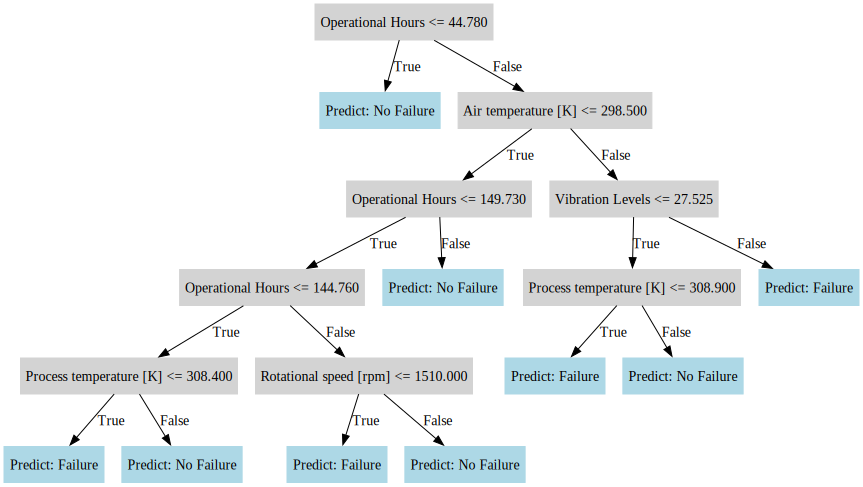

In [29]:
from graphviz import Source

# Usage
graph = visualize_tree_graphviz(tree)
graph.render('custom_tree', format='png', cleanup=True)  # Save file

try:
    # Try to display inline (Jupyter/IPython)
    display(Source(graph.source))
except NameError:
    # If display not available (e.g., plain script), open externally
    graph.view()


In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import random

# 1. Entropy calculation
def entropy(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p + 1e-9) for p in probs if p > 0])

# 2. Split finder
def best_split(X, y, features):
    best_gain = 0
    best_feat, best_thresh = None, None
    base_entropy = entropy(y)
    
    for feat in features:
        thresholds = np.unique(X[feat])
        for t in thresholds:
            left = y[X[feat] <= t]
            right = y[X[feat] > t]
            if len(left) == 0 or len(right) == 0:
                continue
            gain = base_entropy - (len(left)/len(y))*entropy(left) - (len(right)/len(y))*entropy(right)
            if gain > best_gain:
                best_gain = gain
                best_feat, best_thresh = feat, t
    return best_feat, best_thresh, best_gain

# 3. Custom Decision Tree Node
class CustomTree:
    def __init__(self, depth=0, max_depth=5, min_samples=5):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.prediction = None
        self.feature_importance = {}  # <-- track feature importance here

    def fit(self, X, y):
        if len(set(y)) == 1 or self.depth >= self.max_depth or len(y) < self.min_samples:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        feat, thresh, gain = best_split(X, y, X.columns)
        if feat is None:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        self.feature = feat
        self.threshold = thresh
        
        # Accumulate feature importance by information gain
        self.feature_importance[feat] = self.feature_importance.get(feat, 0) + gain

        mask = X[feat] <= thresh

        self.left = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.left.fit(X[mask], y[mask])

        self.right = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.right.fit(X[~mask], y[~mask])

        # Merge children's feature importance into this node
        for tree in [self.left, self.right]:
            for f, imp in tree.feature_importance.items():
                self.feature_importance[f] = self.feature_importance.get(f, 0) + imp

    def predict_row(self, row):
        if self.prediction is not None:
            return self.prediction
        if row[self.feature] <= self.threshold:
            return self.left.predict_row(row)
        else:
            return self.right.predict_row(row)

    def predict(self, X):
        return X.apply(self.predict_row, axis=1)

# 4. Mini Random Forest
class RandomForestLite:
    def __init__(self, n_trees=5, sample_size=0.8, max_depth=5):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), int(self.sample_size * len(X)), replace=True)
            X_sample = X.iloc[idxs]
            y_sample = y.iloc[idxs]
            tree = CustomTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]

    def feature_importances(self):
        total_importance = {}
        for tree in self.trees:
            for feat, imp in tree.feature_importance.items():
                total_importance[feat] = total_importance.get(feat, 0) + imp
        total = sum(total_importance.values())
        if total == 0:
            return {feat: 0 for feat in self.trees[0].feature_importance.keys()}
        return {feat: imp / total for feat, imp in total_importance.items()}

# 5. Assume df_custom exists with 'Failure Binary' column
from sklearn.utils import resample

df_majority = df_custom[df_custom['Failure Binary'] == 0]
df_minority = df_custom[df_custom['Failure Binary'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority), 
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns=['Failure Binary'])
y = df_balanced['Failure Binary']

# One-hot encode 'Type' if it exists
if 'Type' in X.columns:
    X = pd.get_dummies(X, columns=['Type'])

# 6. Train/test split
split = int(0.7 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 7. Train & Evaluate
rf_lite = RandomForestLite(n_trees=5, max_depth=5)
rf_lite.fit(X_train, y_train)
y_pred = rf_lite.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

print("\nFeature Importances:")
importances = rf_lite.feature_importances()
for feat, imp in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")


Confusion Matrix:
[[ 91  38]
 [  0 152]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.71      0.83       129
     Failure       0.80      1.00      0.89       152

    accuracy                           0.86       281
   macro avg       0.90      0.85      0.86       281
weighted avg       0.89      0.86      0.86       281


Feature Importances:
Process temperature [K]: 0.3604
Operational Hours: 0.2744
Air temperature [K]: 0.1645
Rotational speed [rpm]: 0.0774
Torque [Nm]: 0.0740
Vibration Levels: 0.0493


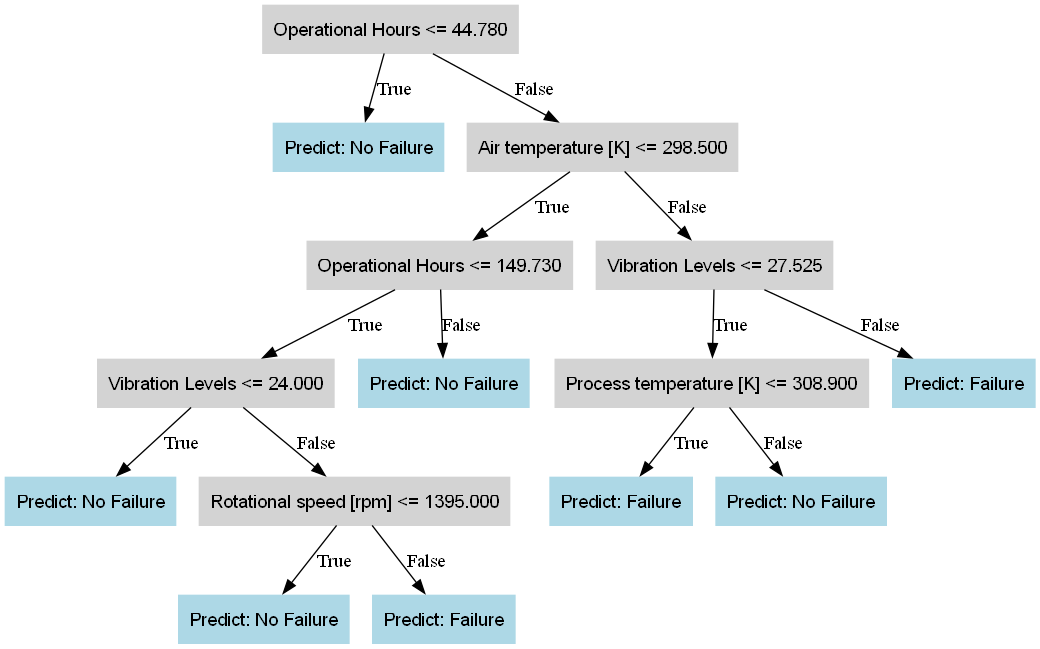

In [44]:
from graphviz import Digraph
import numpy as np
from IPython.display import Image, display

def visualize_custom_tree(node, graph=None, node_id=0, class_names=None):
    """
    Visualize CustomTree recursively with graphviz.
    
    Parameters:
    - node: instance of CustomTree
    - graph: Digraph object (start with None)
    - node_id: current node id for unique graph nodes
    - class_names: list of class names (e.g. ["No Failure", "Failure"])
    
    Returns:
    - graphviz.Digraph object
    """
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box', style='filled', color='lightgrey', fontname="helvetica")
    
    if node.prediction is not None:
        class_label = class_names[node.prediction] if class_names else str(node.prediction)
        label = f"Predict: {class_label}"
        graph.node(str(node_id), label=label, color='lightblue')
        return graph
    
    # Internal node label with feature and threshold
    label = f"{node.feature} <= {node.threshold:.3f}"
    graph.node(str(node_id), label=label)
    
    # Left child edge (True branch)
    left_id = node_id * 2 + 1
    graph.edge(str(node_id), str(left_id), label="True")
    visualize_custom_tree(node.left, graph, left_id, class_names)
    
    # Right child edge (False branch)
    right_id = node_id * 2 + 2
    graph.edge(str(node_id), str(right_id), label="False")
    visualize_custom_tree(node.right, graph, right_id, class_names)
    
    return graph

# Usage example after you train your RandomForestLite and have a tree:
# Visualize the first tree from your rf_lite forest:

class_names = ["No Failure", "Failure"]
graph = visualize_custom_tree(rf_lite.trees[0], class_names=class_names)

# Render and display in Jupyter notebook
png_bytes = graph.pipe(format='png')
display(Image(png_bytes))


c:\Users\Kristina Abramoff\repos\genai_sap_maintenance\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Confusion Matrix:
[[97  6]
 [ 0 84]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.94      0.97       103
     Failure       0.93      1.00      0.97        84

    accuracy                           0.97       187
   macro avg       0.97      0.97      0.97       187
weighted avg       0.97      0.97      0.97       187


Feature Importances:
Operational Hours: 0.5427
Air temperature [K]: 0.1312
Rotational speed [rpm]: 0.1034
Process temperature [K]: 0.1022
Torque [Nm]: 0.0575
Vibration Levels: 0.0562
Type_0: 0.0043
Type_2: 0.0024
Type_1: 0.0001


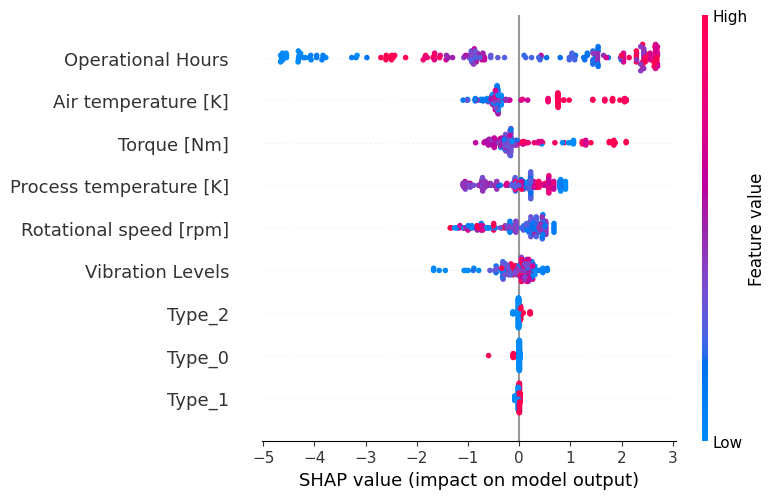

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import shap


# --- 1. Preprocessing: Balance the dataset ---

df_majority = df_custom[df_custom['Failure Binary'] == 0]
df_minority = df_custom[df_custom['Failure Binary'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority), 
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns=['Failure Binary'])
y = df_balanced['Failure Binary']

# Optional: One-hot encode 'Type' if it exists
if 'Type' in X.columns:
    X = pd.get_dummies(X, columns=['Type'])

# --- 2. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Train Gradient Boosted Tree ---
gbdt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)
gbdt.fit(X_train, y_train)

# --- 4. Evaluate Model ---
y_pred = gbdt.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

# --- 5. Feature Importances ---
print("\nFeature Importances:")
importances = gbdt.feature_importances_
for feat, imp in sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

# --- 6. SHAP Values ---
# ⚠️ Use TreeExplainer explicitly for sklearn GBDT
explainer = shap.TreeExplainer(gbdt)
shap_values = explainer.shap_values(X_test)
# --- 7. SHAP Summary Plot ---
shap.summary_plot(shap_values, X_test)


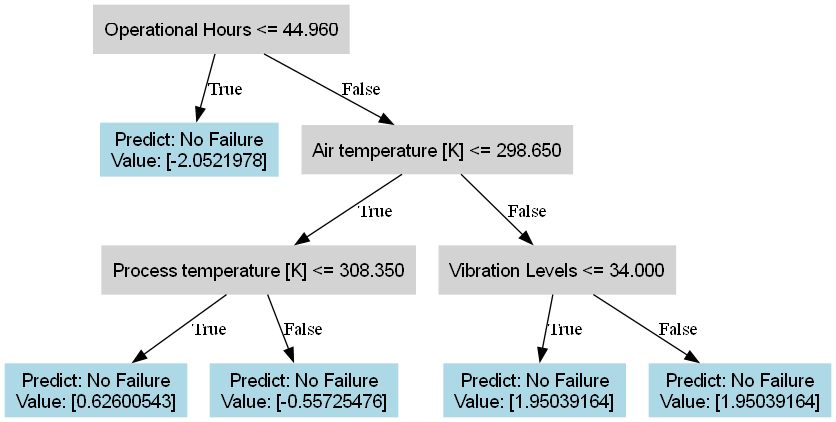

In [42]:
from graphviz import Digraph
import numpy as np
from IPython.display import Image, display

def visualize_sklearn_tree(tree, feature_names=None, class_names=None, node_id=0, graph=None):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box', style='filled', color='lightgrey', fontname="helvetica")
    
    if tree.feature[node_id] == -2:  # leaf
        value = tree.value[node_id][0]
        predicted_class = np.argmax(value)
        class_label = class_names[predicted_class] if class_names else str(predicted_class)
        label = f"Predict: {class_label}\nValue: {value}"
        graph.node(str(node_id), label=label, color='lightblue')
        return graph
    
    feat = feature_names[tree.feature[node_id]] if feature_names else f"X[{tree.feature[node_id]}]"
    threshold = tree.threshold[node_id]
    label = f"{feat} <= {threshold:.3f}"
    graph.node(str(node_id), label=label)
    
    left_id = tree.children_left[node_id]
    graph.edge(str(node_id), str(left_id), label="True")
    visualize_sklearn_tree(tree, feature_names, class_names, left_id, graph)
    
    right_id = tree.children_right[node_id]
    graph.edge(str(node_id), str(right_id), label="False")
    visualize_sklearn_tree(tree, feature_names, class_names, right_id, graph)
    
    return graph


# Usage:
estimator_tree = gbdt.estimators_[0, 0].tree_
feature_names = X.columns.tolist()
class_names = ["No Failure", "Failure"]

graph = visualize_sklearn_tree(estimator_tree, feature_names, class_names)

# Render to PNG bytes in memory
png_bytes = graph.pipe(format='png')

# Display inline in notebook
display(Image(png_bytes))


In [40]:
graph.view()


'gbdt_tree_pretty.pdf'

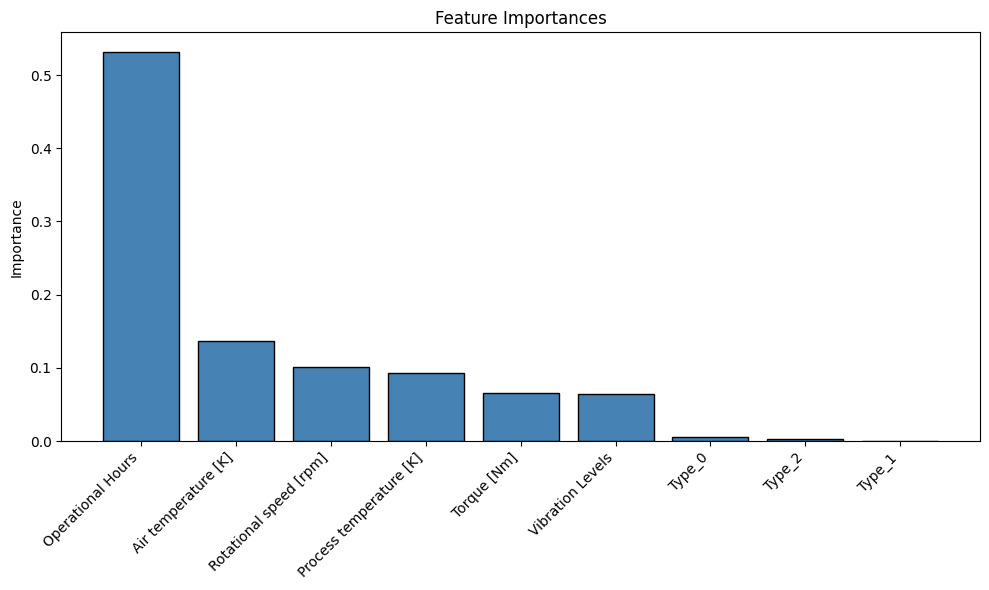

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# - X (feature DataFrame)
# - gbdt (trained GradientBoostingClassifier)

importances = gbdt.feature_importances_
features = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_importances)), sorted_importances, color='steelblue', edgecolor='black')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=45, ha='right')
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

